# Content of the notebook

This notebook contains all steps to train KM prediction models (fully-connected neural networks and gradient boosting models) with extended-connectivity fingerprints, MACCS keys fingerprints, RDKit fingerpints, and task-specific (generated with the GNN) fingerprints as inputs. The notebook consists of the following steps:

1. Loading training and test data data"
2. Training Neural Networks and Gradient Boosting models for all four fingerprints
3. Comparing the performance of the four different fingerprints and plotting figure 2 of our paper

All datasets are stored in one directory. The location of this directory can be changed (to the corresponding path on your PC) in the python file "directory_infomation.py".

Loading all the necessary packages and functions to execute the code:

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('CCB_plot_style_0v4.mplstyle')
c_styles      = mpl.rcParams['axes.prop_cycle'].by_key()['color']   # fetch the defined color styles
high_contrast = ['#004488', '#DDAA33', '#BB5566', '#000000']        # define a high contrast color scheme

import numpy as np
import pickle
import os
from os.path import join
from sklearn.metrics import r2_score
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials


from directory_infomation import *
from build_FCNN_and_load_FPs import *

## 1. Loading training and test data

In [4]:
brenda_train = pd.read_pickle(join(datasets_dir, "splits", "training_data.pkl"))
brenda_train = brenda_train.loc[~pd.isnull(brenda_train["GNN FP"])]
[train_ECFP, train_RDKIT, train_MACCS, train_GNN, train_Y, train_indices] = create_input_and_output_data_FCNN(df = brenda_train)

brenda_test = pd.read_pickle(join(datasets_dir, "splits", "test_data.pkl"))
brenda_test = brenda_test.loc[~pd.isnull(brenda_test["GNN FP"])]
[test_ECFP, test_RDKIT, test_MACCS, test_GNN, test_Y, test_indices] = create_input_and_output_data_FCNN(df = brenda_test)


with open(join(datasets_dir, "splits", "CV_indices_test"), 'rb') as fp:
    CV_indices_test = pickle.load(fp)
    
with open(join(datasets_dir, "splits", "CV_indices_train"), 'rb') as fp:
    CV_indices_train = pickle.load(fp)

Adding MW and LogP to all fingerprints:

In [3]:
mw_logp_train = train_GNN[:, 51:]
mw_logp_test = test_GNN[:, 51:]

train_ECFP = np.concatenate([train_ECFP, mw_logp_train], axis =1)
test_ECFP = np.concatenate([test_ECFP, mw_logp_test], axis =1)

train_RDKIT = np.concatenate([train_RDKIT, mw_logp_train], axis =1)
test_RDKIT = np.concatenate([test_RDKIT, mw_logp_test], axis =1)

train_MACCS = np.concatenate([train_MACCS, mw_logp_train], axis =1)
test_MACCS = np.concatenate([test_MACCS, mw_logp_test], axis =1)


2

## 2. Training Neural Networks and Gradient Boosting models for all four fingerprints

### (a)  Performing hyperparameter optimization for all three different fingerprints with a 5-fold Cross Validation on the training set:

We perform a hyperparameter search for all four different fingerprints with a 5-fold Cross Validation on the training set:

#### (i) Fully Connected Neural Netowrks

In [4]:
'''
space = {"learning_rate": hp.uniform("learning_rate", 1e-5, 1e-1),
        "hidden_layer_size1": hp.choice("hidden_layer_size1", [256,128,64]),
        "hidden_layer_size2": hp.choice("hidden_layer_size2", [128,64,32]),
        "batch_size": hp.choice("batch_size", [8,16,32,64,96]),
        "decay": hp.uniform("decay", 1e-9, 1e-5),
        "l2_parameter": hp.uniform("l2_parameter", 0, 5),
        "momentum": hp.uniform("momentum", 0.1, 1),
        "num_epochs": hp.uniform("max_delta_step", 30, 150)}
    
trials = Trials()
best = fmin(fn = cross_validation_mse_ecfp, space = space, algo=tpe.suggest, max_evals= 500, trials=trials)''';

In [5]:
'''
space = {"learning_rate": hp.uniform("learning_rate", 1e-5, 1e-1),
    "hidden_layer_size1": hp.choice("hidden_layer_size1",[128,64,32]),
    "hidden_layer_size2": hp.choice("hidden_layer_size2", [64,32,16]),
    "batch_size": hp.choice("batch_size", [8,16,32,64,96]),
    "decay": hp.uniform("decay", 1e-9, 1e-5),
    "l2_parameter": hp.uniform("l2_parameter", 0, 5),
    "momentum": hp.uniform("momentum", 0.1, 1),
    "num_epochs": hp.uniform("max_delta_step", 30, 150)}

trials = Trials()
best = fmin(fn = cross_validation_mse_maccs, space = space, algo=tpe.suggest, max_evals = 500, trials=trials)''';

In [6]:
'''
space = {"learning_rate": hp.uniform("learning_rate", 1e-5, 1e-1),
    "hidden_layer_size1": hp.choice("hidden_layer_size1", [256,128,64]),
    "hidden_layer_size2": hp.choice("hidden_layer_size2", [128,64,32]),
    "batch_size": hp.choice("batch_size", [8,16,32,64,96]),
    "decay": hp.uniform("decay", 1e-9, 1e-5),
    "l2_parameter": hp.uniform("l2_parameter", 0, 5),
    "momentum": hp.uniform("momentum", 0.1, 1),
    "num_epochs": hp.uniform("max_delta_step", 30, 150)}

trials = Trials()
best = fmin(fn = cross_validation_mse_rdkit, space = space, algo=tpe.suggest, max_evals = 500, trials=trials)''';

In [7]:
'''
space = {"learning_rate": hp.uniform("learning_rate", 1e-5, 1e-1),
    "hidden_layer_size1": hp.choice("hidden_layer_size1", [64,32,16]),
    "hidden_layer_size2": hp.choice("hidden_layer_size2", [32,16,8]),
    "batch_size": hp.choice("batch_size", [8,16,32,64,96,128]),
    "decay": hp.uniform("decay", 1e-9, 1e-5),
    "l2_parameter": hp.uniform("l2_parameter", 0, 5),
    "momentum": hp.uniform("momentum", 0.1, 1),
    "num_epochs": hp.uniform("num_epochs", 30, 150),
    "third_layer" : hp.choice("third_layer", [True, False])}

trials = Trials()
best = fmin(fn = cross_validation_mse_gnn, space = space, algo=tpe.suggest, max_evals = 500, trials=trials)''';

#### (i) Gradient boosting models

Defining the search space:

In [8]:
space_gradient_boosting = {"learning_rate": hp.uniform("learning_rate", 0.01, 1),
    "max_depth": hp.uniform("max_depth", 2, 7),
    "reg_lambda": hp.uniform("reg_lambda", 0, 5),
    "reg_alpha": hp.uniform("reg_alpha", 0, 5),
    "max_delta_step": hp.uniform("max_delta_step", 0, 5),
    "min_child_weight": hp.uniform("min_child_weight", 0.1, 15),
    "num_rounds":  hp.uniform("num_rounds", 30, 500)}

Hyperparameter optimization:

In [9]:
'''
trials = Trials()
best = fmin(fn = cross_validation_mse_gradient_boosting_ecfp, space = space_gradient_boosting,
            algo=tpe.suggest, max_evals = 200, trials=trials)''';

In [10]:
'''trials = Trials()
best = fmin(fn = cross_validation_mse_gradient_boosting_maccs, space = space_gradient_boosting,
            algo=tpe.suggest, max_evals = 200, trials=trials)''';

In [11]:
'''trials = Trials()
best = fmin(fn = cross_validation_mse_gradient_boosting_rdkit, space = space_gradient_boosting,
            algo=tpe.suggest, max_evals = 200, trials=trials)''';

In [12]:
'''trials = Trials()
best = fmin(fn = cross_validation_mse_gradient_boosting_gnn, space = space_gradient_boosting,
            algo=tpe.suggest, max_evals = 200, trials=trials)''';

### (b) Training the models with the best set of found hyperparameters:

For all four fingerprints, the Gradient Boosting model performed better than the Neural Network. Therefore, for each Fingerprint we are training the Gradient Boosting model with the best set of hyperparameters:

#### (i) Morgan ECFPs:

Repeat Cross-Validation:

In [78]:
best_ecfp_param = {'learning_rate': 0.17961672743999327,
                   'max_delta_step': 0.541592858971679,
                   'max_depth': 5.2483897992786845,
                   'min_child_weight': 14.71725105729986,
                   'num_rounds': 356.1010382190816,
                   'reg_alpha': 4.677518807102969,
                   'reg_lambda': 2.577891289401163}

param = best_ecfp_param
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

R2 = []
MSE = []

for i in range(5):
    train_index, test_index  = CV_indices_train[i], CV_indices_test[i]
    train_index = [True if ind in train_index else False for ind in list(brenda_train.index)]
    test_index = [True if ind in test_index else False for ind in list(brenda_train.index)]
    
    dtrain = xgb.DMatrix(train_ECFP[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_ECFP[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    
MSE_ECFP = MSE
R2_ECFP = R2
print(MSE)
print(R2)

[0.9088630245552416, 0.8255313897054934, 0.8596503150675787, 0.861651385068267, 0.8533668753743515]
[0.36724161118373344, 0.40196954250285777, 0.386331700353879, 0.37696625085076385, 0.3642439369345516]


Train on whole training data set and validate on test set:

In [79]:
dtrain = xgb.DMatrix(train_ECFP, label = train_Y)
dtest = xgb.DMatrix(test_ECFP)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)
MSE_ECFP_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
R2_ECFP_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
absolute_errors_ECFP = abs(np.reshape(test_Y, (-1)) - y_test_pred)

print(MSE_ECFP_test, R2_ECFP_test)

0.8326369525829513 0.39754653536435347


#### (ii) RDKit Fingerprint:

Repeat cross validation:

In [80]:
best_rdkit_param =  {'learning_rate': 0.08080539993579965,
                     'max_delta_step': 0.5563363519825201,
                     'max_depth': 6.106661180002159,
                     'min_child_weight': 12.946306298352344,
                     'num_rounds': 205.64790226508674,
                     'reg_alpha': 4.205629205102807,
                     'reg_lambda': 1.7165448547821038}

param = best_rdkit_param
num_round = param["num_rounds"]
del param["num_rounds"]

param["max_depth"] = int(np.round(param["max_depth"]))

R2 = []
MSE = []

for i in range(5):
    train_index, test_index  = CV_indices_train[i], CV_indices_test[i]
    train_index = [True if ind in train_index else False for ind in list(brenda_train.index)]
    test_index = [True if ind in test_index else False for ind in list(brenda_train.index)]
    
    dtrain = xgb.DMatrix(train_RDKIT[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_RDKIT[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    
MSE_RDKIT = MSE
R2_RDKIT = R2
print(MSE)
print(R2)

[0.9058947621287066, 0.841221250621057, 0.8664122868588362, 0.8417153331176507, 0.8559646100451503]
[0.3693081414527113, 0.3906035123089625, 0.3815046123406909, 0.39138139995313814, 0.3623086314816991]


Train on whole training data set and validate on test set:

In [81]:
dtrain = xgb.DMatrix(train_RDKIT, label = train_Y)
dtest = xgb.DMatrix(test_RDKIT)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)
MSE_RDKIT_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
R2_RDKIT_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
absolute_errors_RDKIT = abs(np.reshape(test_Y, (-1)) - y_test_pred)

print(MSE_RDKIT_test, R2_RDKIT_test)

0.8323001987933114 0.3977901931634319


#### (iii) MACCS Fingerprint

Repeat cross validation:

In [82]:
best_maccs_param =  {'learning_rate': 0.10963465489904332,
                     'max_delta_step': 0.35473911287958093,
                     'max_depth': 6.844816088955529,
                     'min_child_weight': 4.88695168154169,
                     'num_rounds': 416.2972036014347,
                     'reg_alpha': 4.826776174061548,
                     'reg_lambda': 4.434825494851664}

param = best_maccs_param
num_round = param["num_rounds"]
del param["num_rounds"]

param["max_depth"] = int(np.round(param["max_depth"]))

R2 = []
MSE = []

for i in range(5):
    train_index, test_index  = CV_indices_train[i], CV_indices_test[i]
    train_index = [True if ind in train_index else False for ind in list(brenda_train.index)]
    test_index = [True if ind in test_index else False for ind in list(brenda_train.index)]
    
    dtrain = xgb.DMatrix(train_MACCS[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_MACCS[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    
MSE_MACCS = MSE
R2_MACCS = R2
print(MSE)
print(R2)

[0.8890756117600703, 0.8361999890232733, 0.8326477146340963, 0.8695021590837361, 0.8532062905007362]
[0.38101778108044804, 0.3942410086028425, 0.40560772410864965, 0.37128959640171, 0.3643635722402844]


Train on whole training data set and validate on test set:

In [83]:
dtrain = xgb.DMatrix(train_MACCS, label = train_Y)
dtest = xgb.DMatrix(test_MACCS)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)
MSE_MACCS_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
R2_MACCS_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
absolute_errors_MACCS = abs(np.reshape(test_Y, (-1)) - y_test_pred)

print(MSE_MACCS_test, R2_MACCS_test)

0.8273874823460501 0.4013447832344632


#### (iv) GNN Fingerprint

Repeat cross validation:

In [75]:
best_gnn_param = best_gnn_param = {'learning_rate': 0.11663442585733919,
                 'max_delta_step': 4.103293476480144,
                 'max_depth': 4.953377961760086,
                 'min_child_weight': 9.731324861736825,
                 'num_rounds': 82.28862882817994,
                 'reg_alpha': 0.54379272012357756,
                 'reg_lambda': 4.683671598466882}
param = best_gnn_param
num_round = param["num_rounds"]
del param["num_rounds"]

param["max_depth"] = int(np.round(param["max_depth"]))

R2 = []
MSE = []

for i in range(5):
    train_index, test_index  = CV_indices_train[i], CV_indices_test[i]
    train_index = [True if ind in train_index else False for ind in list(brenda_train.index)]
    test_index = [True if ind in test_index else False for ind in list(brenda_train.index)]
    
    dtrain = xgb.DMatrix(train_GNN[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_GNN[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    
MSE_GNN = MSE
R2_GNN = R2
print(MSE_GNN)
print(R2_GNN)

#np.save(join(datasets_dir, "training_results", "XGB_substrate_only_MSE_CV.npy"), MSE_GNN)
#np.save(join(datasets_dir, "training_results", "XGB_substrate_only_MSE_R2_CV.npy"), R2_GNN)

[0.839462772935518, 0.8269895971580745, 0.8338728769850635, 0.8276153275599089, 0.8401994616480103]
[0.41555867350435016, 0.40091318961201994, 0.404733132098933, 0.40157668249767786, 0.37405362530303954]


Train on whole training data set and validate on test set:

In [77]:
dtrain = xgb.DMatrix(train_GNN, label = train_Y)
dtest = xgb.DMatrix(test_GNN)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#pickle.dump(bst, open(join(datasets_dir, "model_weights", "xgboost_model_substrate_only.dat"), "wb"))
y_test_pred = bst.predict(dtest)
MSE_GNN_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
R2_GNN_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
absolute_errors_GNN = abs(np.reshape(test_Y, (-1)) - y_test_pred)

print(MSE_GNN_test, R2_GNN_test)
#np.save(join(datasets_dir, "training_results", "XGB_substrate_only_MSE_test.npy"), MSE_GNN_test)
#np.save(join(datasets_dir, "training_results", "XGB_substrate_only_MSE_R2_test.npy"), R2_GNN_test)

0.8015024995970341 0.42007383133976584


#### Training the xgboost model with all training and test data for the predictions of the KM values of the genome-scale models

In [21]:
all_GNN = np.concatenate([train_GNN,test_GNN], axis = 0)
all_Y = np.concatenate([train_Y,test_Y], axis = 0)

best_gnn_param = best_gnn_param = {'learning_rate': 0.11663442585733919,
                 'max_delta_step': 4.103293476480144,
                 'max_depth': 4.953377961760086,
                 'min_child_weight': 9.731324861736825,
                 'num_rounds': 82.28862882817994,
                 'reg_alpha': 0.49379272012357756,
                 'reg_lambda': 4.683671598466882}

param = best_gnn_param
num_round = param["num_rounds"]
del param["num_rounds"]

param["max_depth"] = int(np.round(param["max_depth"]))


dtrain = xgb.DMatrix(all_GNN, label = all_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
pickle.dump(bst, open(join(datasets_dir, "model_weights", "xgboost_model_substrate_only_trained_with_all_data.dat"), "wb"))

2

## 3. Comparing the performance of the four different fingerprints and plotting figure 2 of our paper

#### Figure 2a

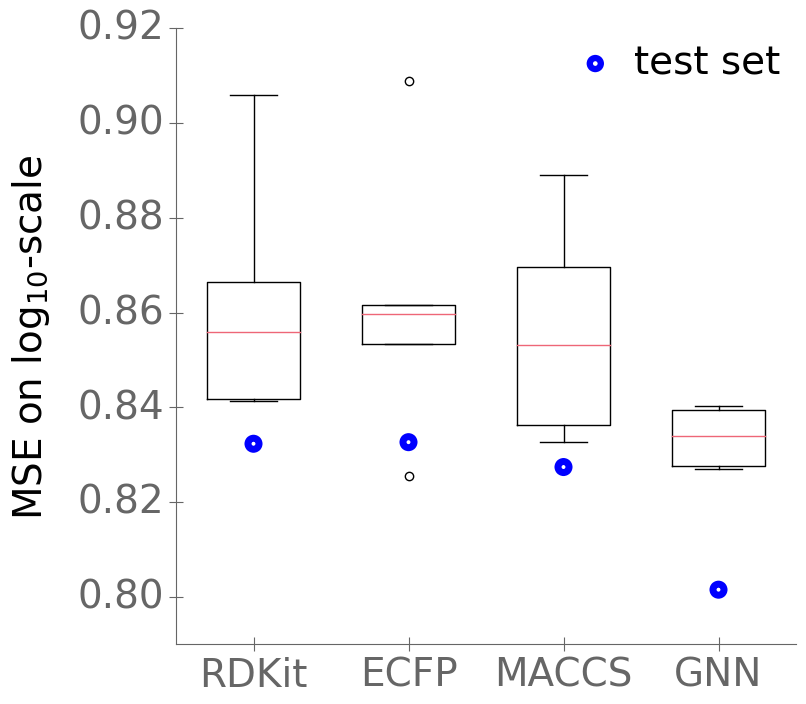

In [85]:
fig, ax = plt.subplots(figsize= (8,8))
ax.plot(fillstyle= "full")
plt.rcParams.update({'font.size': 28})
labs = ["RDKit",  "ECFP", "MACCS", "GNN"]
    

plt.scatter(1, MSE_RDKIT_test , c='blue', marker='o', linewidths= 8, label = "test set")
plt.scatter(3, MSE_MACCS_test, c='blue', marker='o', linewidths= 8)
plt.scatter(2, MSE_ECFP_test, c='blue', marker='o', linewidths= 8)
plt.scatter(4, MSE_GNN_test, c='blue', marker='o', linewidths= 8)

plt.boxplot([MSE_RDKIT,  MSE_ECFP, MSE_MACCS, MSE_GNN], positions=[1,2,3,4],  widths=0.6, whis =2)
plt.ylim(0.79, 0.92)
plt.xlim(0.5, 4.5)

ax.set_xticks([1,2,3,4])
ax.set_xticklabels(labs)
ax.tick_params(axis='x', length=10)
ax.tick_params(axis='y', length=10)
ax.yaxis.set_label_coords(-0.2, 0.5)

plt.ylabel("MSE on $\log_{10}$-scale")
plt.legend(loc = "upper right")

plt.show()

#### Figure 2b

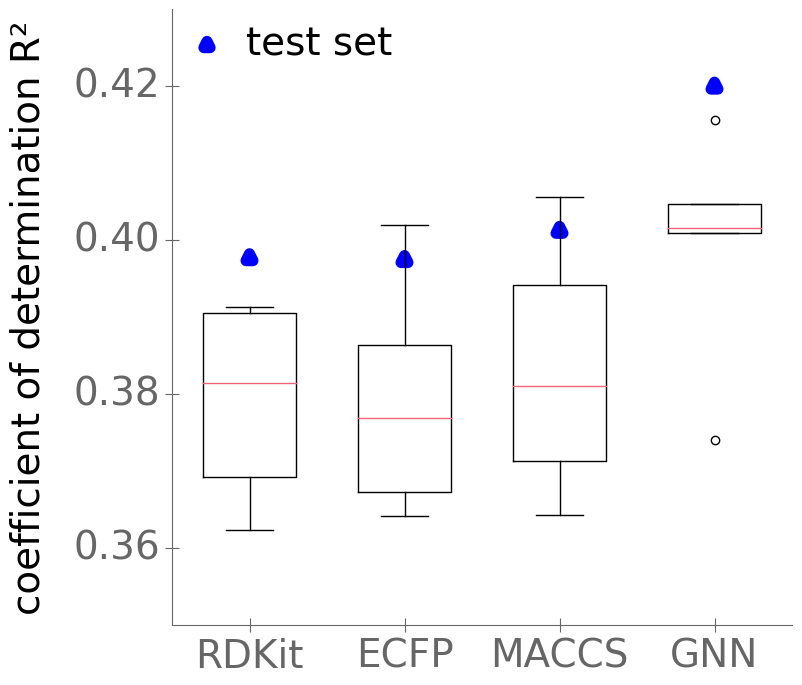

In [86]:
fig, ax = plt.subplots(figsize= (8,8))
plt.rcParams.update({'font.size': 28})
labs = ["RDKit",  "ECFP", "MACCS", "GNN"]
    

plt.scatter(1, R2_RDKIT_test , c='blue', marker='^', linewidths= 8, label = "test set")
plt.scatter(3, R2_MACCS_test, c='blue', marker='^', linewidths= 8)
plt.scatter(2, R2_ECFP_test, c='blue', marker='^', linewidths= 8)
plt.scatter(4, R2_GNN_test, c='blue', marker='^', linewidths= 8)

plt.boxplot([R2_RDKIT, R2_ECFP, R2_MACCS, R2_GNN], positions=[1,2,3,4], widths=0.6, whis =2)
plt.ylim(0.35, 0.43)
plt.xlim(0.5, 4.5)

ax.set_xticks([1,2,3,4])
ax.set_xticklabels(labs)
ax.tick_params(axis='x', length=10)
ax.tick_params(axis='y', length=10)
ax.yaxis.set_label_coords(-0.2, 0.5)

plt.ylabel("coefficient of determination R²")
plt.legend(loc = "upper left")
plt.show()